# **1. 데이터 차원**
- 데이터 자체는 충분함
- 불균형 데이터 -> Data Augmentation
- 데이터 범위(scale) 조정: 정규화/규제화/표준화

# **2. 알고리즘 차원**
- 학습률(learning rate)
    - lr scheduling
    - 초기 lr: 1e-5
    - min_lr: 1e-12
- 활성화 함수/손실함수
    - 활성화 함수: softmax
    - 손실 함수: CrossEntropyLoss
- 배치/ Epoch
    - 충분한 학습이 이루어질 수 있도록 Epoch 수 증가
    - batch size: 128
    - Epoch: 200

# **3. 하드웨어 차원**
- 역전파처럼 복잡한 미적분 연산의 경우 병렬 연산을 해야 속도/ 정확도 증가
- 장치를 cpu에서 gpu로 변경

In [1]:
### 필요한 라이브러리 준비

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
import argparse

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact
from module.pytorchtools import EarlyStopping # 사용자 정의 모듈
                                              # 외부 py파일을 모듈로 import하여 EarlyStopping 함수 사용

In [2]:
### gpu 장치 확인
print(torch.__version__) 

1.12.1+cu116


### **DataLoader**

In [3]:
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

# 분류에 사용할 class 정의(7개의 감정들)
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [4]:
IMAGE_SIZE = 48

### 이미지 파일 경로를 리스트 형태로 저장하기 위한 함수
def list_image_file(data_dir,sub_dir):
    image_files = []
    
    images_dir = os.path.join(data_dir,sub_dir)
    for file_path in os.listdir(images_dir):
        image_files.append(os.path.join(sub_dir,file_path))
    return image_files

In [5]:
### 학습 데이터셋 클래스
class Feeling_dataset(Dataset):
    ### 생성자
    def __init__(self,data_dir,transform = None):
        self.data_dir = data_dir # 데이터가 저장된 상위 directory
        angry_imgs = list_image_file(data_dir,'angry')
        disgust_imgs = list_image_file(data_dir,'disgust')
        fear_imgs = list_image_file(data_dir,'fear')
        happy_imgs = list_image_file(data_dir,'happy')
        neutral_imgs = list_image_file(data_dir,'neutral')
        sad_imgs = list_image_file(data_dir,'sad')
        surprise_imgs = list_image_file(data_dir,'surprise')
        
        # 모든 사진들의 경로를 하나의 리스트에 저장
        self.files_path = angry_imgs + disgust_imgs + fear_imgs + happy_imgs + neutral_imgs + sad_imgs + surprise_imgs
        self.transform = transform
    
    ### 데이터 개수 확인
    def __len__(self):
        return len(self.files_path) # 전체 데이터 개수
    
    ### getitem
    def __getitem__(self,index):
        # image(feature data)
        image_file = os.path.join(self.data_dir,self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.resize(image,dsize = (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # feeling(target data)
        target = feelings_list.index(self.files_path[index].split(os.sep)[0])
        
        if self.transform:
            image = self.transform(image) # feature data에 대해서만 데이터 변형 수행
            target = torch.Tensor([target]).long()
            
        return {'image':image,'target':target}

In [6]:
### Transformation

# 학습 feature data 변환
train_transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 수평으로 뒤집기
    transforms.RandomVerticalFlip(), # 수직으로 뒤집기
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

# 검증 feature data 변환
val_transformer = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

In [7]:
### 데이터로더 구현
def build_dataloader(train_data_dir,val_data_dir):
    dataloaders = {}
    train_dset = Feeling_dataset(train_data_dir,train_transformer)
    dataloaders['train'] = DataLoader(train_dset,batch_size = 64,shuffle = True, drop_last = True)
    
    val_dset = Feeling_dataset(val_data_dir,val_transformer)
    dataloaders['val'] = DataLoader(val_dset,batch_size = 64,shuffle = False, drop_last = False)
    
    return dataloaders

In [8]:
train_data_dir = './DataSet/archive/train/'
val_data_dir = train_data_dir = './DataSet/archive/valid/'
dataloaders = build_dataloader(train_data_dir,val_data_dir)

### **Modeling**

In [9]:
from torchsummary import summary

In [10]:
### 모델 생성 함수
# 기존의 VGG19 모델 호출 -> head 부분 수정
def build_vgg19_based_model():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # gpu 할당
    model = models.vgg19(pretrained = True) # 이미 학습된 vgg19 모델 불러오기
    # 일반 NN Layer(FC Layer)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1)) # 각 구역의 평균값 출력
    model.classifier = nn.Sequential(
        nn.Flatten(), # 평탄화
        nn.Linear(512,256), # 512 -> 256
        nn.ReLU(), # 활성화 함수
        nn.Dropout(0.1), # 과적합 방지
        nn.Linear(256,7), # 256 -> 7(7개의 감정으로 분류되니)
        nn.Softmax() # 활성화 함수(각 클래스에 속할 확률 추정)
    )
    
    return model.to(device)

### **Estimation**

In [11]:
### 모델 검증을 위한 accuracy

@torch.no_grad() 
def get_accuracy(image,target,model):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # gpu 할당
    batch_size = image.shape[0] 
    prediction = model(image).to(device) # 예측 
    _,pred_label = torch.max(prediction,dim = 1) # 예측이 어느 클래스에 속하는지 확률이 가장 높은 1개 선택
    is_correct = (pred_label == target)
    
    return is_correct.cpu().numpy().sum() / batch_size

### **Training**

In [12]:
### Epoch을 1번 수행

def train_one_epoch(dataloaders, model, optimizer, loss_function, device):
    losses = {}  # loss값 저장
    accuracies = {} # 정확도 계산
    
    for tv in ["train", "val"]: 
        ### loss, accuracy 갱신
        running_loss = 0.0 
        running_correct = 0.0
        
        if tv == "train":
            model.train() # 학습
        else:
            model.eval() # 평가
            
            
        for index, batch in enumerate(dataloaders[tv]): 
            image = batch['image'].to(device) # feature data(이미지)
            label = batch['target'].squeeze(dim = 1).to(device) # label data(감정), 1차원으로 차원 축소
            
            ### 역전파 적용
            with torch.set_grad_enabled(tv == 'train'):
                prediction = model(image) # label 예측
                loss = loss_func(prediction, label) # loss 값 계산
                
                if tv == 'train':
                    optimizer.zero_grad() # gradient를 0으로 초기화
                    loss.backward() # 역전파 적용
                    optimizer.step() # 가중치 업데이트
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image, label, model)
            
            ### 학습 과정 monitoring
            if tv == 'train':
                if index % 50 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
                    
        ### loss, accuracy 저장            
        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
        
    return losses, accuracies

In [13]:
### 학습이 잘 된 모델 저장
def save_best_model(model_state,model_name,save_dir = './best_model'):
    os.makedirs(save_dir,exist_ok = True) # 경로 존재 시 덮어쓰기, 없는 경우 새로 생성
    torch.save(model_state,os.path.join(save_dir,model_name)) # 모델 저장

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # 장치 얻어오기

### 경로 설정
train_data_dir = './DataSet/archive/train/'
val_data_dir = './DataSet/archive/valid/'

### 필요한 요소들 준비
dataloaders = build_dataloader(train_data_dir,val_data_dir)
model = build_vgg19_based_model().to(device)
loss_func = nn.CrossEntropyLoss(reduction = 'mean').to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 5, factor = 0.1,
                                                       min_lr = 1e-12,verbose = True)  # lr scheduling
early_stopping = EarlyStopping(patience = 10, verbose = False) # 조기 종료(사용자 정의 모듈)

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
num_epochs = 200

best_acc = 0.0
train_loss,train_accuracy = [],[]
val_loss,val_accuracy = [],[]

for epoch in range(num_epochs):
    ### 1 Epoch 수행
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    
    # LR Scheduling
    scheduler.step(losses['val']) # 1 Epoch 수행 후 learning rate 조정
    
    # EarlyStopping
    early_stopping(losses['val'], model) # 현재 과적합 상황 추적
    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break
        
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss:{losses['train']}, Val Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc:{accuracies['train']}, Val Acc:{accuracies['val']}")
    
    # deepcopy: 배열의 내부 객체까지 복사를 해서 사용
    # copy: 배열의 내부 객체까지 깊은 복사를 해주지 않음
    if (epoch > 3) and (accuracies['val'] > best_acc):
        best_acc = accuracies['val']
        best_model = copy.deepcopy(model.state_dict()) 
        save_best_model(best_model, f'model_{epoch+1:02d}.pth')

print(f'Bset Accuracy: {best_acc}')

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0/455 - Running loss: 1.9419102668762207
50/455 - Running loss: 1.8291348218917847
100/455 - Running loss: 1.8164948225021362
150/455 - Running loss: 1.7394955158233643
200/455 - Running loss: 1.7702958583831787
250/455 - Running loss: 1.7147512435913086
300/455 - Running loss: 1.7238383293151855
350/455 - Running loss: 1.8046784400939941
400/455 - Running loss: 1.6744788885116577
450/455 - Running loss: 1.6652601957321167
1/200-Train Loss:1.7655670223655282, Val Loss:1.711456585348698
1/200-Train Acc:0.39563873626373625, Val Acc:0.4456865150163545
0/455 - Running loss: 1.637462854385376
50/455 - Running loss: 1.7089037895202637
100/455 - Running loss: 1.6701252460479736
150/455 - Running loss: 1.7452739477157593
200/455 - Running loss: 1.6305718421936035
250/455 - Running loss: 1.68937349319458
300/455 - Running loss: 1.7449966669082642
350/455 - Running loss: 1.674289584159851
400/455 - Running loss: 1.6687941551208496
450/455 - Running loss: 1.6455527544021606
2/200-Train Loss:1.686

15/200-Train Loss:1.5399962532651292, Val Loss:1.5741369766101503
15/200-Train Acc:0.6373626373626373, Val Acc:0.5845134552482901
0/455 - Running loss: 1.4706324338912964
50/455 - Running loss: 1.4787791967391968
100/455 - Running loss: 1.6175514459609985
150/455 - Running loss: 1.5572314262390137
200/455 - Running loss: 1.5047695636749268
250/455 - Running loss: 1.5410077571868896
300/455 - Running loss: 1.560025691986084
350/455 - Running loss: 1.533551573753357
400/455 - Running loss: 1.369619607925415
450/455 - Running loss: 1.4899293184280396
16/200-Train Loss:1.5323173067071936, Val Loss:1.5702906637861018
16/200-Train Acc:0.645467032967033, Val Acc:0.5888761894142135
0/455 - Running loss: 1.488106369972229
50/455 - Running loss: 1.51256263256073
100/455 - Running loss: 1.4613569974899292
150/455 - Running loss: 1.4895213842391968
200/455 - Running loss: 1.516858696937561
250/455 - Running loss: 1.6146597862243652
300/455 - Running loss: 1.473919153213501
350/455 - Running loss: 

50/455 - Running loss: 1.4791187047958374
100/455 - Running loss: 1.4713943004608154
150/455 - Running loss: 1.4447165727615356
200/455 - Running loss: 1.4425567388534546
250/455 - Running loss: 1.4708876609802246
300/455 - Running loss: 1.5409576892852783
350/455 - Running loss: 1.4141294956207275
400/455 - Running loss: 1.505725383758545
450/455 - Running loss: 1.439108967781067
30/200-Train Loss:1.4608723050945407, Val Loss:1.5457556456850285
30/200-Train Acc:0.717239010989011, Val Acc:0.6139142878382396
0/455 - Running loss: 1.3874677419662476
50/455 - Running loss: 1.419269323348999
100/455 - Running loss: 1.4987138509750366
150/455 - Running loss: 1.4317017793655396
200/455 - Running loss: 1.423604130744934
250/455 - Running loss: 1.42424738407135
300/455 - Running loss: 1.453766107559204
350/455 - Running loss: 1.438826560974121
400/455 - Running loss: 1.511202096939087
450/455 - Running loss: 1.3760261535644531
EarlyStopping counter: 1 out of 10
31/200-Train Loss:1.456099051433

100/455 - Running loss: 1.504437804222107
150/455 - Running loss: 1.4739923477172852
200/455 - Running loss: 1.4190382957458496
250/455 - Running loss: 1.3146562576293945
300/455 - Running loss: 1.3981189727783203
350/455 - Running loss: 1.4221869707107544
400/455 - Running loss: 1.4008640050888062
450/455 - Running loss: 1.4070570468902588
44/200-Train Loss:1.4126178875074282, Val Loss:1.537925264291596
44/200-Train Acc:0.7554601648351649, Val Acc:0.6226862176628011
0/455 - Running loss: 1.4522228240966797
50/455 - Running loss: 1.410226583480835
100/455 - Running loss: 1.3971613645553589
150/455 - Running loss: 1.3625357151031494
200/455 - Running loss: 1.4182167053222656
250/455 - Running loss: 1.4342008829116821
300/455 - Running loss: 1.4852845668792725
350/455 - Running loss: 1.4247279167175293
400/455 - Running loss: 1.5127946138381958
450/455 - Running loss: 1.3207709789276123
EarlyStopping counter: 1 out of 10
45/200-Train Loss:1.4091992003577096, Val Loss:1.5395536004451282
4

150/455 - Running loss: 1.4317219257354736
200/455 - Running loss: 1.4285731315612793
250/455 - Running loss: 1.32914400100708
300/455 - Running loss: 1.4041160345077515
350/455 - Running loss: 1.3704110383987427
400/455 - Running loss: 1.3313238620758057
450/455 - Running loss: 1.3989548683166504
EarlyStopping counter: 4 out of 10
58/200-Train Loss:1.3991807314065787, Val Loss:1.5374909911239356
58/200-Train Acc:0.7681318681318682, Val Acc:0.6229603404698186
0/455 - Running loss: 1.4033162593841553
50/455 - Running loss: 1.4604564905166626
100/455 - Running loss: 1.3404585123062134
150/455 - Running loss: 1.3692505359649658
200/455 - Running loss: 1.3345046043395996
250/455 - Running loss: 1.405440092086792
300/455 - Running loss: 1.412178635597229
350/455 - Running loss: 1.475853443145752
400/455 - Running loss: 1.4624203443527222
450/455 - Running loss: 1.3103435039520264
EarlyStopping counter: 5 out of 10
59/200-Train Loss:1.3994537628613986, Val Loss:1.5376214730112177
59/200-Trai

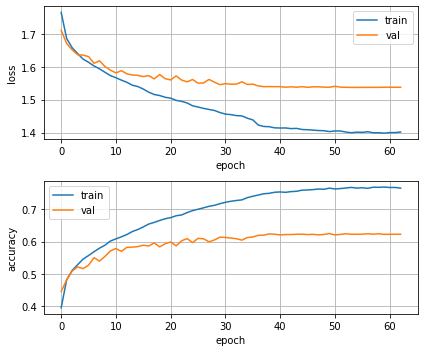

In [16]:
### Loss, Accuracy 시각화

plt.figure(figsize = (6,5))

# Loss
plt.subplot(211)
plt.plot(train_loss,label = "train")
plt.plot(val_loss,label = "val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()

# Accuracy
plt.subplot(212)
plt.plot(train_accuracy,label = "train")
plt.plot(val_accuracy,label = "val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()

plt.tight_layout()